# Amazon Reviews - Sampling, Exploration and Experimentation 

The first stage to any data science project working with extremely large datasets is to first take a look at a sample of the data and perform some basic exploration and modelling processes.

In the following notebook, we're going to be taking our pre-processed dataset from our AWS GLUE process (step 0), and then apply sampling techniques in order to generate a statistically sound sample of the 145million reviews data. Based on this sample dataset, we're going to start to explore the characteristics of the data (e.g. descriptive statistics), and then proceed with basic modelling the data to understand the predictive nature of the features for different predictive tasks.

Once we get a better unstanding of what models work well with our data (Applied to the sample), we will move forward and take this model and apply it to the entire dataset!

### Imports

The following imports are required in order to run different statistical tests and modelling techniques.

In [ ]:
# NOTE: Uncomment the folllowing lines on first run of the notebook. 
# !conda install -y -c conda-forge fastparquet scikit-learn arrow-cpp parquet-cpp pyarrow numpy
# !pip install --upgrade mxnet gluonnlp swifter dask cufflinks
# !pip install -q torch==1.4.0
# !pip install -q transformers

In [247]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 
import csv
import itertools
import dask.dataframe as dd
from dask.multiprocessing import get
import multiprocessing
import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics


### Configs and Global Vars

Throughout the notebook we're going to store all our global variables (although all variables inside a notebook are global if they are not defined in a method), inside an array.

In [248]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv',
    'wordvecdata': 'wordvec-data',
    'models_dir': 'models'
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [249]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [250]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

Processed 100 files
Processed 200 files
Training Dataset Size 241


In [251]:
def count_lines(configs, global_vars, entry):
        
    s3 = boto3.client('s3')
    resp = s3.select_object_content(
        Bucket=configs['bucket_name'],
        Key=entry['path_with_prefix'],
        ExpressionType='SQL',
        Expression="SELECT count(*) FROM s3object s",
        InputSerialization = {'CSV':
                              {"FileHeaderInfo": "Use", 
                               "AllowQuotedRecordDelimiter": True,
                               "QuoteEscapeCharacter":"\\",
                              }, 
                              'CompressionType': 'NONE'},
        OutputSerialization = {'CSV':{}},
    )
    
    for event in resp['Payload']:
        if 'Records' in event:
            records = event['Records']['Payload'].decode('utf-8')
            return(int(records))
    
count_lines(configs, global_vars, manifest[240])

5259983

### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

In [ ]:
def generate_manifest_statistics(configs, global_vars, manifest):
    
    date_cnt = {}
    stats = {}

    for entry in manifest:
        
        date = entry['date']
        cnt = count_lines(configs, global_vars, entry)
        date_cnt[date] = cnt
        print(date,cnt)

    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    df_stats.plot.kde()
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(df_stats.sum()['files']))
    print('Date with most files {}. Files: {}'.format(df_stats.max()['date'], df_stats.max()['files']))
    print('Date with least files {}. Files: {}'.format(df_stats.min()['date'], df_stats.min()['files']))
    print('File Kurtosis/Skew {}/{}'.format(df_stats.kurtosis()['files'], df_stats.skew()['files']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs,global_vars, manifest)

1995-06 2
1995-07 23
1995-08 19
1995-09 27
1995-10 45
1995-11 46
1995-12 39
1996-01 69
1996-02 30
1996-05 348
1996-06 434
1996-07 415
1996-08 468
1996-09 586
1996-10 541
1996-11 657
1996-12 1118
1997-01 1567
1997-02 1510
1997-03 2056
1997-04 2590
1997-05 1655
1997-06 3273
1997-07 3498
1997-08 3472
1997-09 2650
1997-10 4682
1997-11 4555
1997-12 5215
1998-01 6766
1998-02 5199
1998-03 7537
1998-04 8277
1998-05 8950
1998-06 14705
1998-07 18131
1998-08 16007
1998-09 14754
1998-10 18154
1998-11 20523
1998-12 23464
1999-01 25706
1999-02 26085
1999-03 29021
1999-04 30794
1999-05 29571
1999-06 34012
1999-07 34737
1999-08 33653
1999-09 31272
1999-10 35460
1999-11 44151
1999-12 79807
2000-01 83417
2000-02 72891
2000-03 91563
2000-04 94683
2000-05 91532
2000-06 104234
2000-07 90018
2000-08 81110
2000-09 65477
2000-10 71941
2000-11 64477
2000-12 66688
2001-01 70538
2001-02 62081
2001-03 67995
2001-04 63441
2001-05 72208
2001-06 77717
2001-07 82284
2001-08 81643
2001-09 63106
2001-10 71604
2001-11 8

### Generate Sample Dataset

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_dataset(configs, manifest, manifest_df_stats, sample_size_pct = 0.01, strategy = 'binned_normal'):
    
    dfs_sampled = []
    index_key = configs['index_key']+'='

    notes = '''
        Based on the manifest inspection, we can now use a suitable sampling strategy in order to generate a smaller 
        manifest to work on locally.'''
    
    strategies = ['statified', 'random', 'clustered', 'systematic', 'binned_normal']
    if strategy in strategies:
        print('Using {} Strategy'.format(strategy))
    else:
        print('Please use one of these strategies {}'.format(strategies))
    
    if strategy is 'binned_normal':
        sample_meta = {}
        #we take a pct of each of the rows, and then use random to select within each bin
        #workout the overall pct we need to take
        for idx,row in manifest_df_stats.iterrows():
            to_sample = int(row['files'] * sample_size_pct)
            if to_sample < 1:
                to_sample = 1
            date = row['date']    
            tmp = {'rows':row['files'], 'samples': to_sample, 'sampled_added':0}
            sample_meta[date] = tmp
            
#         print(sample_meta)
        #now we generate a new manifest
        
        sampled_manifest = []
        for entry in manifest:

            date = entry['path'].split('/')[1].replace(index_key,'')
            #get the meta data 
            meta = sample_meta[date]
            to_skip = meta['samples']
            if to_skip == 1:
                to_skip = 1
            full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
            df = pd.read_csv(full_path, nrows=int(to_skip), header=0, error_bad_lines=False, escapechar="\\")
            print(date, df.shape)
            dfs_sampled.append(df)
        
    elif strategy in strategies:
        print('Other Stratigies will be supported Soon!')
    
    sampled_data = pd.concat(dfs_sampled)

    print('New Dataset Length {}'.format(sampled_data.shape[0]))
    
    return sampled_data
    
sampled_data = generate_sample_dataset(configs, manifest, manifest_df_stats)

In [6]:
def save_load_sample_df_to_file(df, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfDf = list()
    if operation == 'save':

        numberChunks = len(df) // chunkSize + 1
        for i in range(numberChunks):
            listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfDf)):
            chunk_df = listOfDf[i]
            df_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            chunk_df.to_pickle(df_tmp_name_prefix) 
                       
        return df
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            df = pd.read_pickle(fl)
            loaded.append(df)
                       
        return pd.concat(loaded)
    
sampled_data = save_load_sample_df_to_file(None, path='data', file_name_prefix = 'sample_df', operation='load')   

data/sample_df_part_7.pkl
data/sample_df_part_5.pkl
data/sample_df_part_14.pkl
data/sample_df_part_6.pkl
data/sample_df_part_12.pkl
data/sample_df_part_4.pkl
data/sample_df_part_8.pkl
data/sample_df_part_1.pkl
data/sample_df_part_2.pkl
data/sample_df_part_9.pkl
data/sample_df_part_0.pkl
data/sample_df_part_3.pkl
data/sample_df_part_10.pkl
data/sample_df_part_11.pkl
data/sample_df_part_13.pkl


In [7]:
def ready_sample_data(df):
    
    print('Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))
    df['review_date']= pd.to_datetime(df['review_date']) 
    #convert date to string with format yyyy-mm
    df['review_date_str'] = df['review_date'].dt.strftime('%Y-%m')
    
    #here we need to do some basic filtering of rows, we don't want to start to model for 
    df_len = df.shape[0]
    pct_min = 0.01
    min_product_category_row_count = df_len * pct_min #should be around 1% of the dataset, Imbalanced data will skew our modelling
    
    df = df.groupby('product_category').filter(lambda x : len(x)>min_product_category_row_count)

    print('After Processing Data: Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))

    return df

sampled_data = ready_sample_data(sampled_data)

Dataset Rows 1487293, Columns 18
After Processing Data: Dataset Rows 1437684, Columns 19


### Post Data Load Dataset Review

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'star_rating', 'helpful_votes',
       'total_votes', 'vine', 'verified_purchase', 'review_headline',
       'review_body', 'review_date', 'year', 'product_category', 'body_len',
       'review_body_processed', 'review_date_str'],
      dtype='object')
(1437684, 19)
        customer_id  product_parent   star_rating  helpful_votes
count  1.437684e+06    1.437684e+06  1.437684e+06   1.437684e+06
mean   2.854710e+07    4.998316e+08  4.202209e+00   1.805442e+00
std    1.558695e+07    2.883550e+08  1.252194e+00   1.445953e+01
min    1.001400e+04    5.760000e+02  1.000000e+00   0.000000e+00
25%    1.473634e+07    2.506303e+08  4.000000e+00   0.000000e+00
50%    2.772966e+07    4.998551e+08  5.000000e+00   0.000000e+00
75%    4.330486e+07    7.496030e+08  5.000000e+00   1.000000e+00
max    5.309659e+07    9.999999e+08  5.000000e+00   1.049800e+04


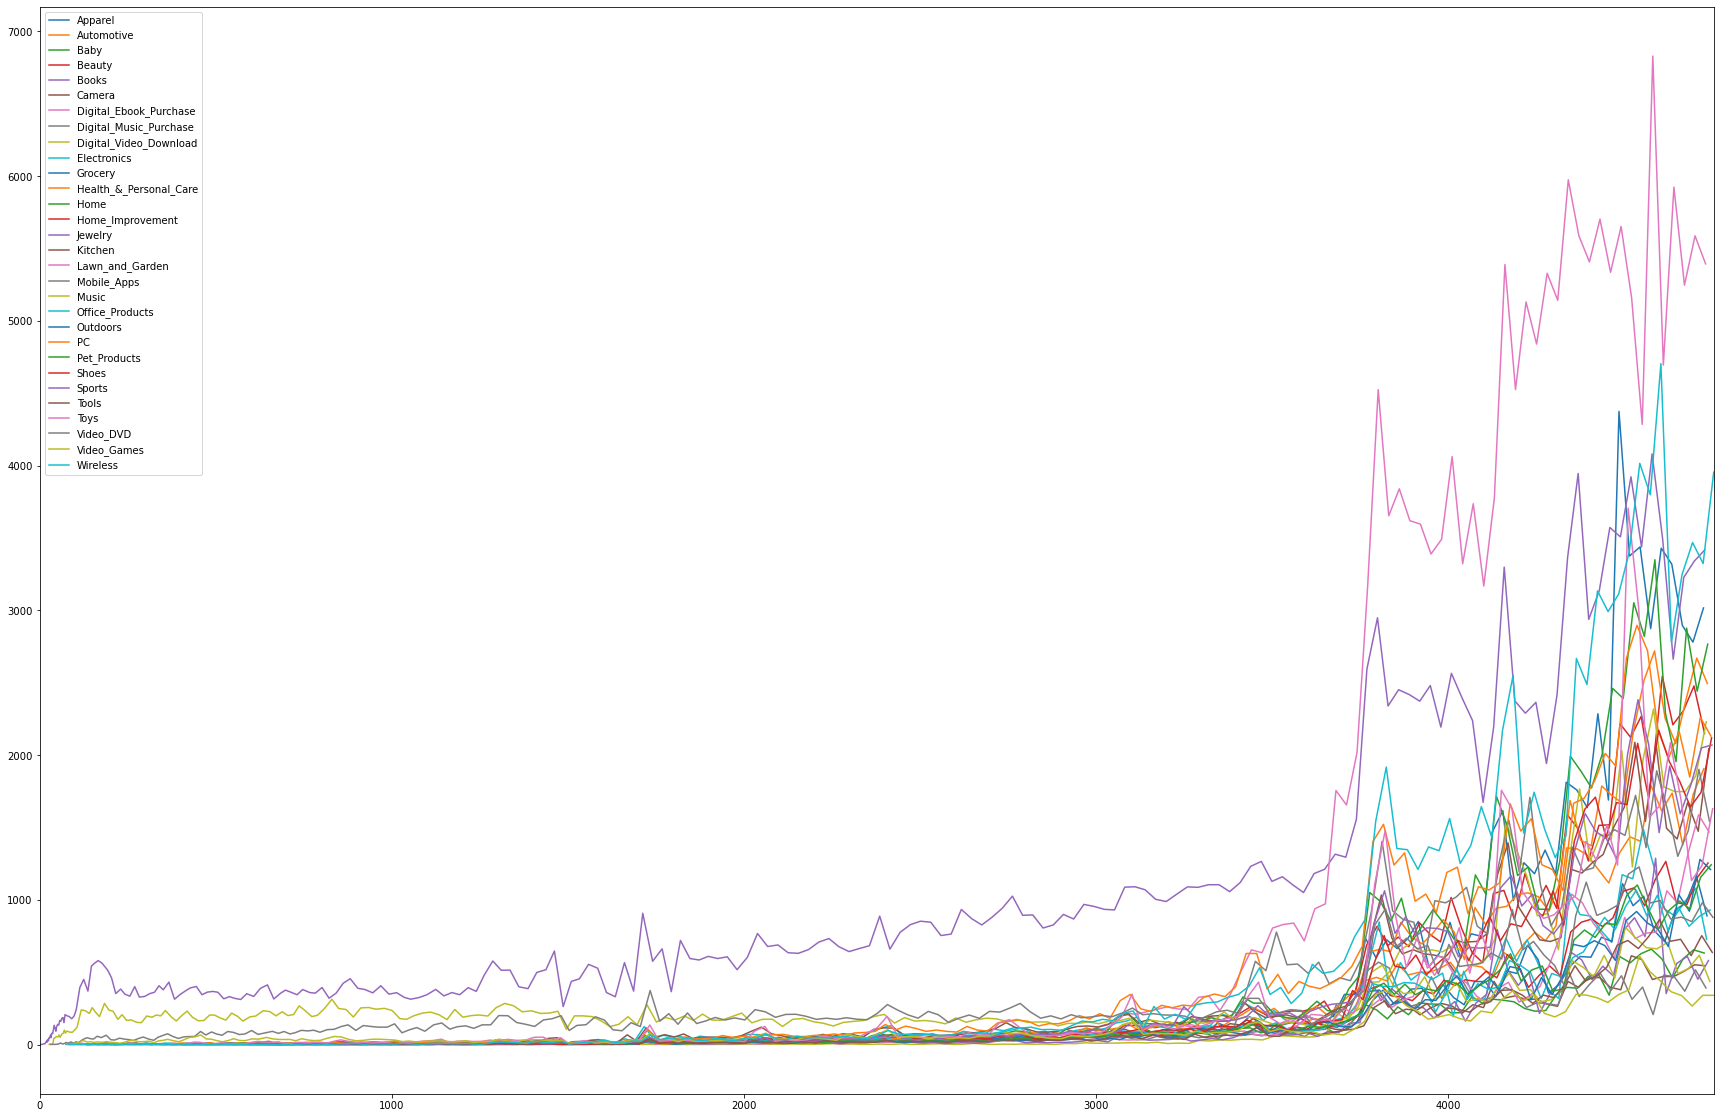

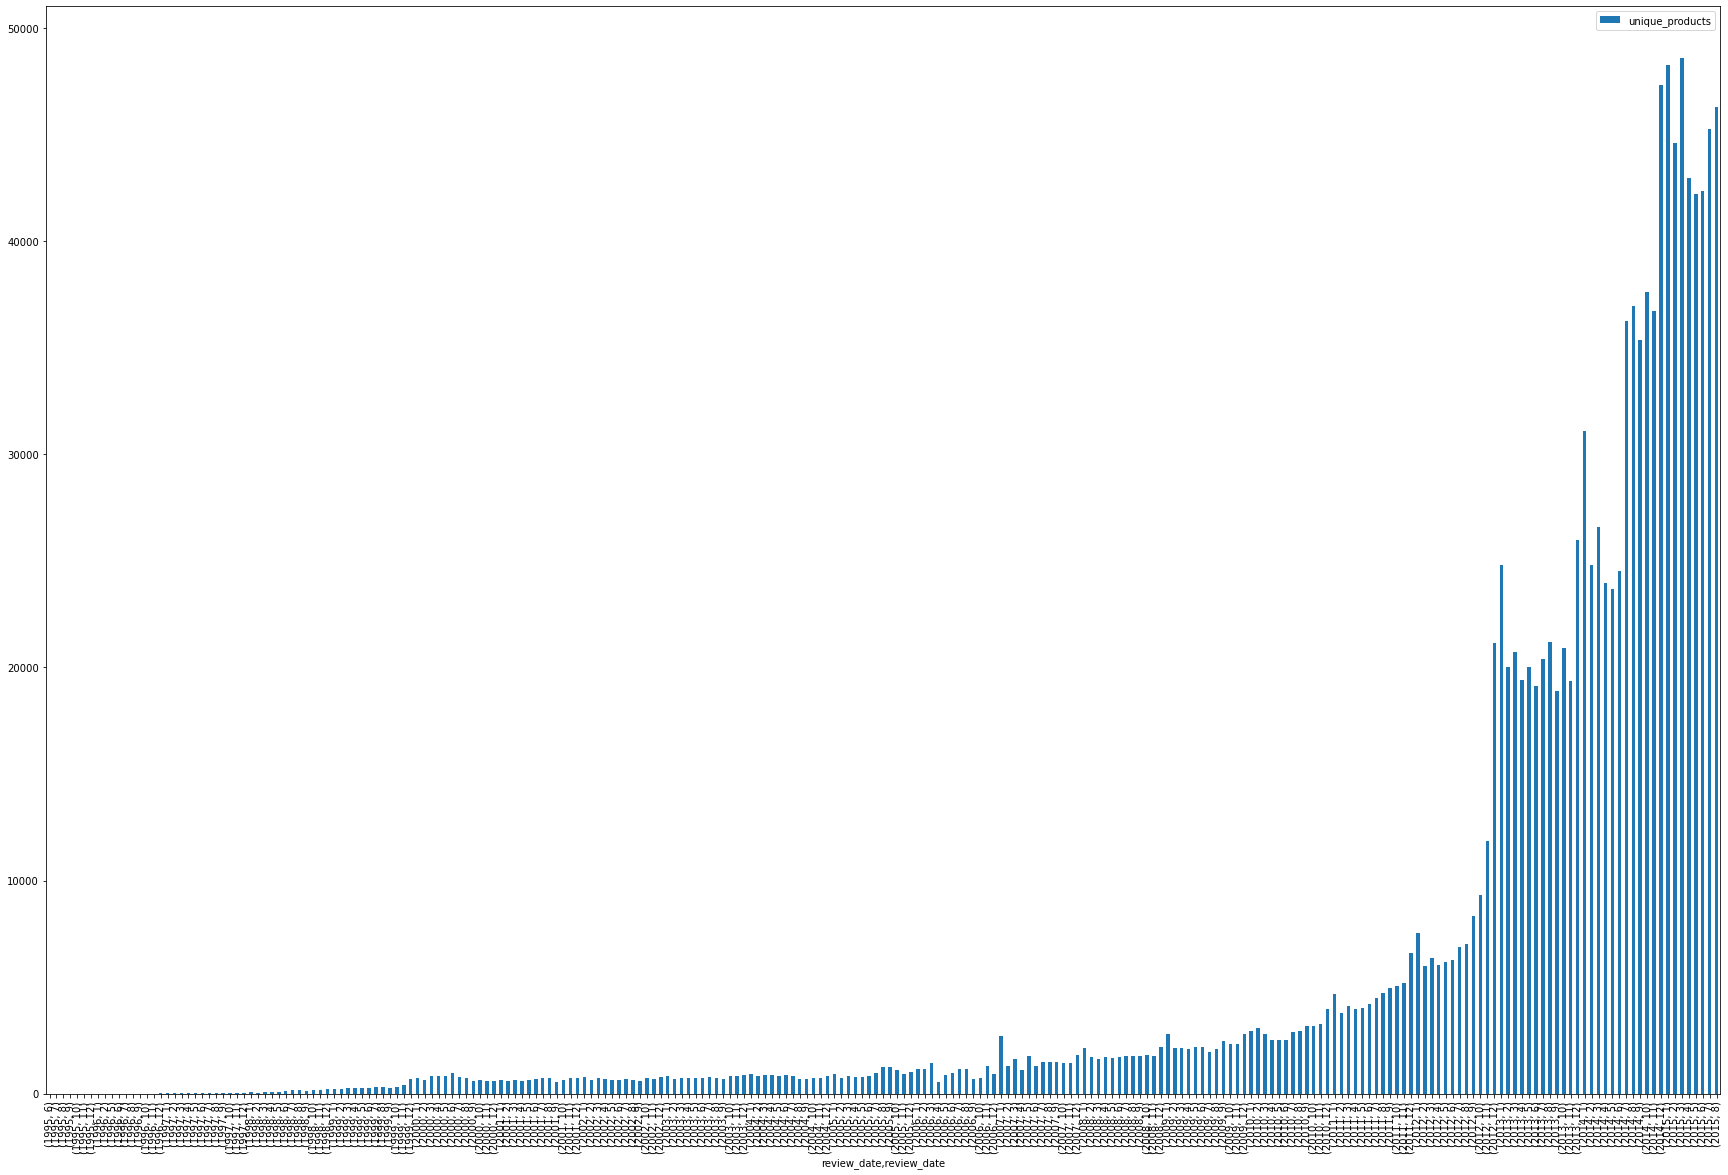

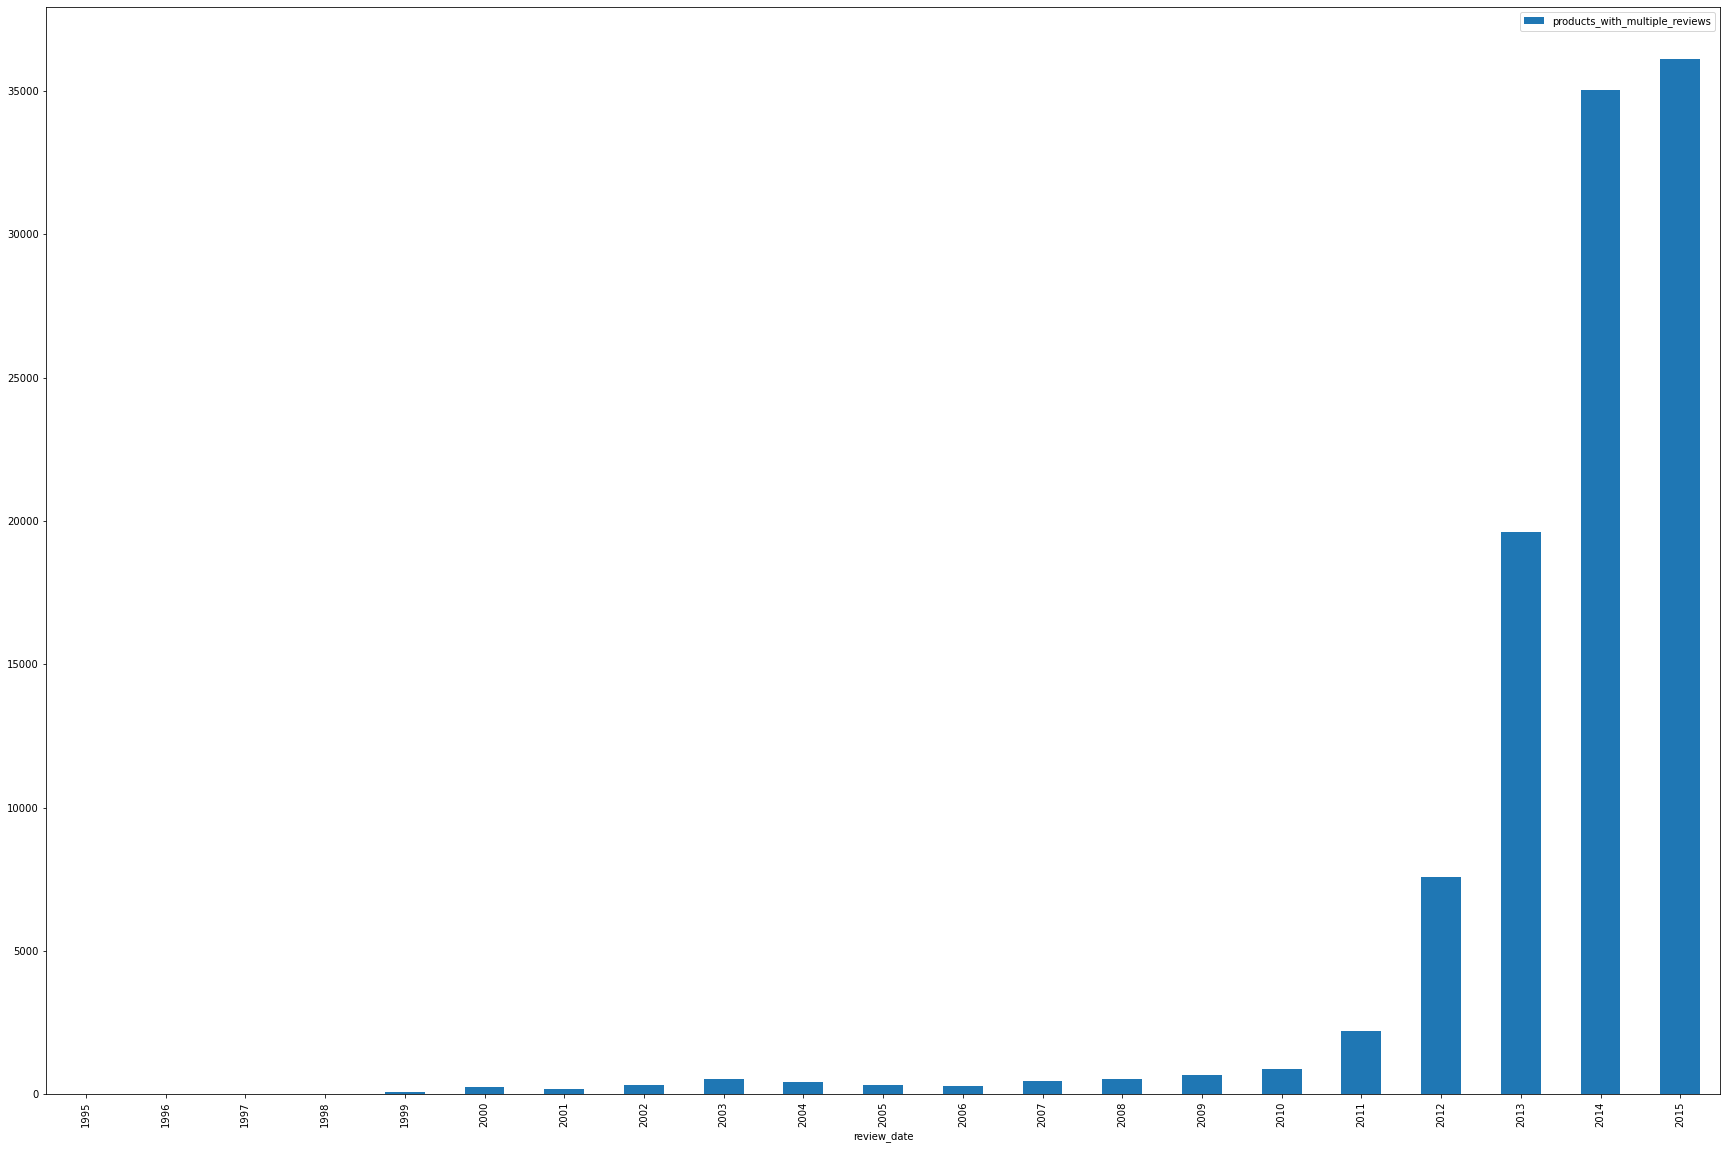

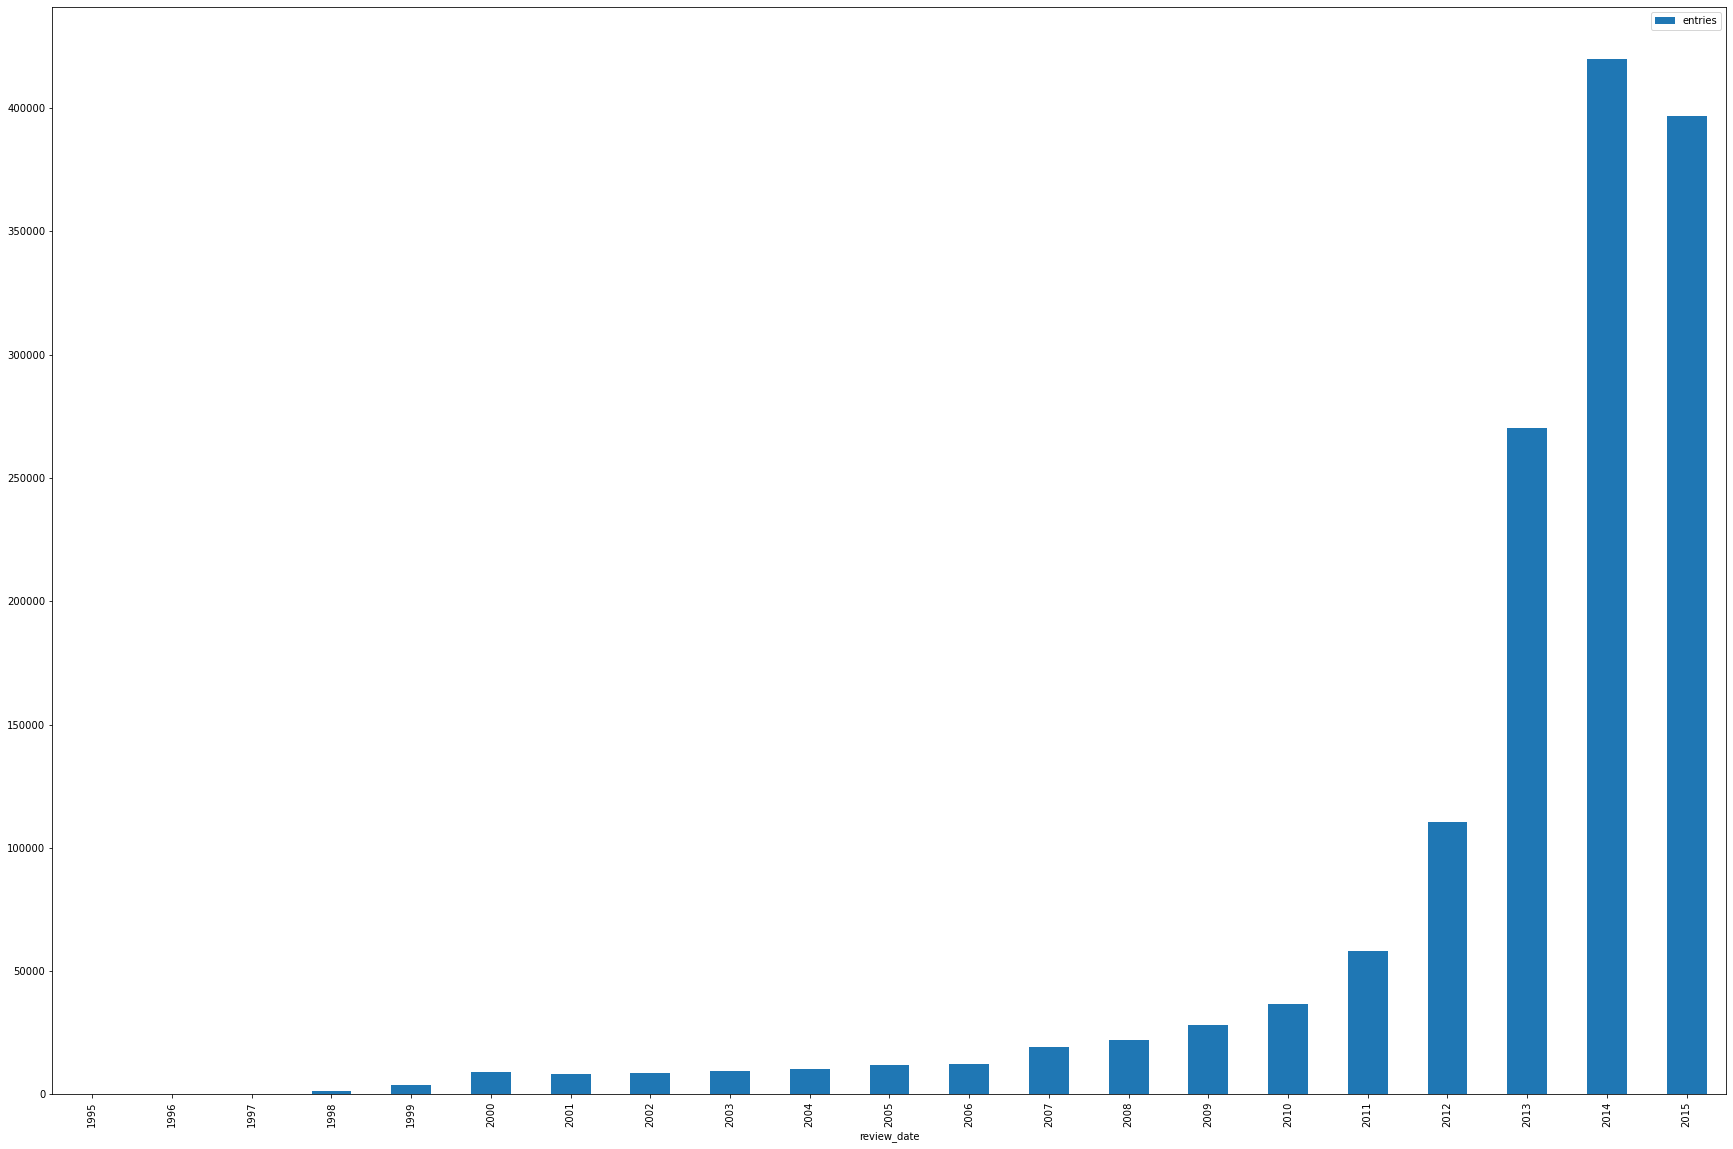

In [13]:
def analyse_sample_dataset(df):
   

    print(df.columns)
    print(df.shape)
    print(df.describe())

#     print(df.groupby(['review_date_str','product_category']).count())
    tmps = []
    for name,group in df.groupby(['review_date_str','product_category']):
        unique_products = len(group['product_id'].unique().tolist())
        products_with_multiple_reviews = group.shape[0]- unique_products
        tmp = {'review_date': name[0],
               'product_category': name[1], 
               'entries':group.shape[0], 
               'unique_products':unique_products,
              'products_with_multiple_reviews':products_with_multiple_reviews }
#         print(name, group.shape[0], unique_products)

        tmps.append(tmp)
    
    df_counts_cat_years = pd.DataFrame(tmps)
    df_counts_cat_years['review_date']= pd.to_datetime(df_counts_cat_years['review_date']) 
    
    df_counts_cat_years.groupby('product_category')['entries'].plot(legend=True, figsize=(30,20))  
    plt.show()    
    
    df_counts_cat_years.groupby([df_counts_cat_years['review_date'].dt.year, df_counts_cat_years['review_date'].dt.month]).sum()['unique_products'].plot(kind='bar', legend=True, figsize=(30,20)) 
    plt.show()
   
    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year).sum()['products_with_multiple_reviews'].plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()

    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year)['entries'].sum().plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()
    
analyse_sample_dataset(sampled_data)

## Model /Analysis Experimentation (Local Mode)

The purpose of this section is to perform some experimentations with different modelling techniques.

We're first going to perform some local experiments on the 1% sample of data to see which methods provide valuable insights for both customers (e.g. Amazon Customer), and operations (e.g. Amazon). 

We want to look at different type of insights, from understanding how customer reviews have changed over times, and whether there is predictability in the type of review, and the category of product it is related to. 

Let's start of by first gettign our data into a shape which we can use for analysis and modelling purposes

### Prep Data for Modelling Purposes

We're going to develop some dataframes which represent our Xs and Ys (features and labels).

Let's create some feature/label datasets which are shaped around the following labels:

- year_product-category
- product-category_star_rating

The features for this model will be only using the text of the reviews





In [234]:
def transform_data_for_modelling_use(df):
    
    #first let's get all our data in correct buckets of features and labels
    tmps = list()
    
    #first let's do the year_product-category grouping
    for name,group in df.groupby([df['review_date'].dt.year,'product_category']):
        label = '{}_{}'.format(name[0],name[1])
#         print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
#             print (type(review)) 
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
#         print(len(tokens))
        tmp = {'tokens':tokens, 'label':label }
#         print(tmp)
        tmps.append(tmp)
    
    df_year_product_category = pd.DataFrame(tmps)

    tmps = list()
    #let's do the product-category-rating grouping
    for name,group in df.groupby(['product_category','star_rating']):
        label = '{}_stars_{}'.format(name[0],name[1])
        print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
        tmp = {'tokens':tokens, 'label':label }
        tmps.append(tmp)
    
    df_product_category_rating = pd.DataFrame(tmps)

    
    return df_year_product_category, df_product_category_rating

df_year_product_category, df_product_category_rating = transform_data_for_modelling_use(sampled_data)        

Apparel_stars_1
Apparel_stars_2
Apparel_stars_3
Apparel_stars_4
Apparel_stars_5
Automotive_stars_1
Automotive_stars_2
Automotive_stars_3
Automotive_stars_4
Automotive_stars_5
Baby_stars_1
Baby_stars_2
Baby_stars_3
Baby_stars_4
Baby_stars_5
Beauty_stars_1
Beauty_stars_2
Beauty_stars_3
Beauty_stars_4
Beauty_stars_5
Books_stars_1
Books_stars_2
Books_stars_3
Books_stars_4
Books_stars_5
Camera_stars_1
Camera_stars_2
Camera_stars_3
Camera_stars_4
Camera_stars_5
Digital_Ebook_Purchase_stars_1
Digital_Ebook_Purchase_stars_2
Digital_Ebook_Purchase_stars_3
Digital_Ebook_Purchase_stars_4
Digital_Ebook_Purchase_stars_5
Digital_Music_Purchase_stars_1
Digital_Music_Purchase_stars_2
Digital_Music_Purchase_stars_3
Digital_Music_Purchase_stars_4
Digital_Music_Purchase_stars_5
Digital_Video_Download_stars_1
Digital_Video_Download_stars_2
Digital_Video_Download_stars_3
Digital_Video_Download_stars_4
Digital_Video_Download_stars_5
Electronics_stars_1
Electronics_stars_2
Electronics_stars_3
Electronics_sta

### Save the features for use later

As these dataframes can take a while to generate, it's useful to save them if the notebook is shutdown, or the kernal dies. These things happen:)

In [ ]:
save_load_sample_df_to_file(df_year_product_category, 
                            path='data', 
                            file_name_prefix = 'features_df_year_product_category', 
                            operation='save', chunkSize=10)   

save_load_sample_df_to_file(df_product_category_rating, 
                            path='data', 
                            file_name_prefix = 'features_df_product_category_star', 
                            operation='save', chunkSize=10)   

## Part 3: Analysis and Modelling 

## Approach 1: TF-IDF - Temporal Analysis of Product Categories


In [235]:
#util code

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [236]:
def generate_label_category(row, grouping_type):
    
    if grouping_type == 'year':
        label = row['label']
        category = "_".join(label.split('_')[1:])
        sub_cat = label.split('_')[0]
        
        
    if grouping_type == 'star':
        label = row['label']
        category = label.split('stars')[0]
        sub_cat = label.split('stars')[1]
        
    return category, sub_cat
        
        
    

def prepare_data_for_tfidf(df, grouping_type):
     
    data_grouped = dict()
    for idx,row in df.iterrows():
#         label = row['label']
#         category = "_".join(label.split('_')[1:])
#         year = label.split('_')[0]
        category, sub_cat = generate_label_category(row, grouping_type)
        if category in data_grouped:
            docs = data_grouped[category]
        else:
            docs = list()

        tokens = row['tokens']
        docs_tmp = [" ".join(x) for x in tokens]
        docs = docs + docs_tmp
        data_grouped[category] = docs
    
    tfidf_handlers = dict()
    for k,v in data_grouped.items():
        print(k, len(v))
        cv = CountVectorizer(max_features=10000)
        word_count_vector=cv.fit_transform(v)
        feature_names=cv.get_feature_names()
        tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        tfidf_handlers[k] = {'cv': cv, 'feature_names': feature_names, 'tfidf_transformer':tfidf_transformer}

    tfidf_scores = {} #keep track of tf-idf scores for category by year
    for idx,row in df.iterrows():
        
        category, sub_cat = generate_label_category(row, grouping_type)

        if category in tfidf_scores:
            sub_scores = tfidf_scores[category]
        else:
            sub_scores = dict()

        tfidf_transformer=tfidf_handlers[category]['tfidf_transformer']
        feature_names=tfidf_handlers[category]['feature_names']
        cv=tfidf_handlers[category]['cv']
        tokens = row['tokens']
        doc = [" ".join(x) for x in tokens]

        tf_idf_vector=tfidf_transformer.transform(cv.transform(doc))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,100)
        
        sub_scores[sub_cat] = keywords
        tfidf_scores[category] = sub_scores

    return tfidf_scores

tfidf_scores = prepare_data_for_tfidf(df_year_product_category, grouping_type='year')

Books 193606
Music 46377
Video_DVD 49250
Automotive 35293
Camera 17565
Electronics 31860
Home_Improvement 26095
Office_Products 25115
PC 68088
Tools 17763
Toys 50558
Video_Games 17170
Wireless 89363
Baby 16649
Home 61812
Kitchen 46492
Lawn_and_Garden 25412
Outdoors 22518
Sports 47688
Beauty 50556
Grocery 23750
Health_&_Personal_Care 52120
Apparel 61003
Jewelry 17951
Pet_Products 25120
Shoes 43825
Digital_Ebook_Purchase 171063
Digital_Video_Download 39863
Digital_Music_Purchase 15862
Mobile_Apps 47897


### Temporal Overlap in TF-IDF Terms

In [237]:
def calc_temporal_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    year_n = keys[i]
                    year_n1 = keys[i+1]
                    bag = '{}_{}'.format(year_n,year_n1)
                    total_terms = set(ordered[year_n].keys()).union(set(ordered[year_n1].keys()))
                    overlap = set(ordered[year_n].keys()).intersection(set(ordered[year_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'year_from_to':year_n1, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
    df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
            
df_overlaps_tfidf = calc_temporal_overlap_tfidf(tfidf_scores)

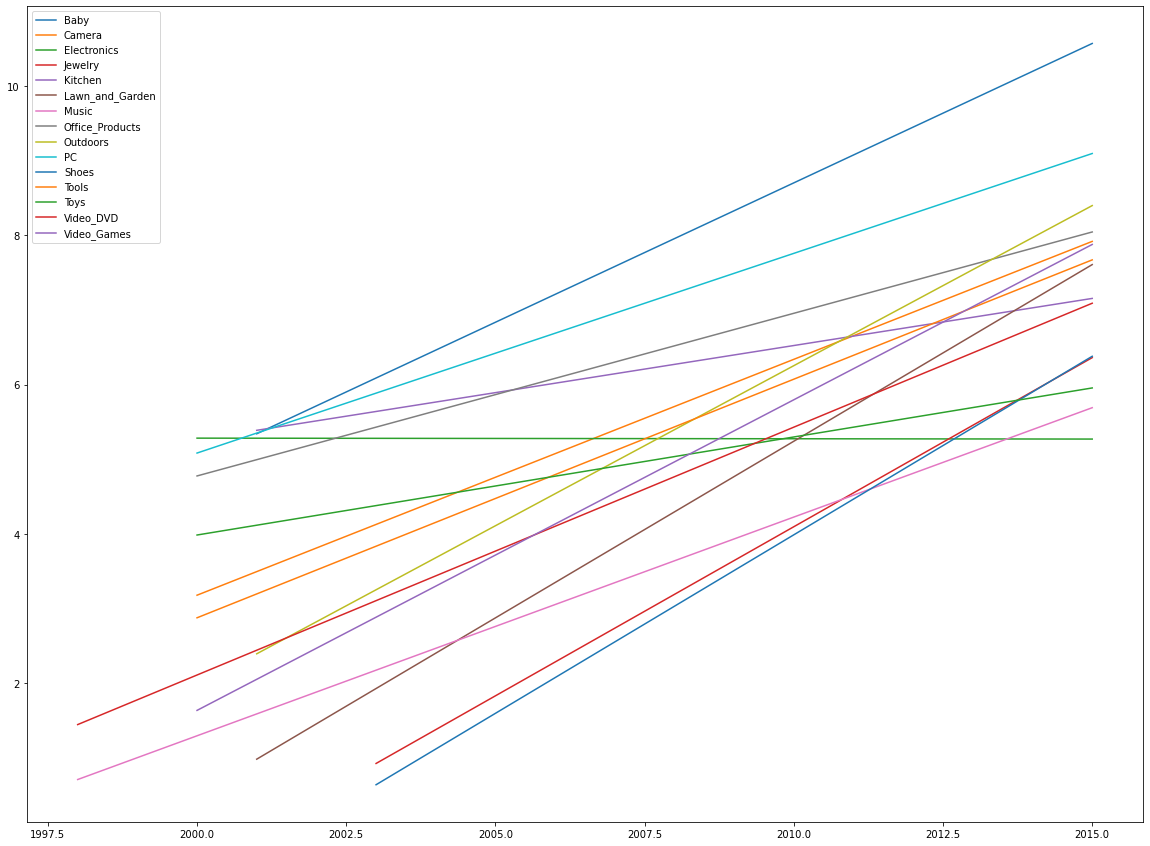

In [238]:
def plot_temporal_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['year_from_to'].dt.year
        y = group['overlap_pct']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        if z[0] < 0.5:
    #     plt.plot(x,y, label=name)
            plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()

plot_temporal_overlap(df_overlaps_tfidf)

**Notes**: At this point we can reflect on the results of the TF-IDF analysis to determine whether the terms which are being identified are useful, and also whether the transfer of terms across the years provides any value with respects to the overall consistency of language used within the reviews. One way of thinking about the results is that the language overlap could be considered as a metric of homogenity within the review samples. The current approach does not normalize against new products being introduced throughout the years, so it may be that this analysis is contaminated due to this factor.

### Perform Same exploration with Product Cateogry - Star Rating Analysis

In [239]:
def calc_star_rating_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    star_n = keys[i]
                    star_n1 = keys[i+1]
                    bag = '{}_{}'.format(star_n,star_n1)
                    total_terms = set(ordered[star_n].keys()).union(set(ordered[star_n1].keys()))
                    overlap = set(ordered[star_n].keys()).intersection(set(ordered[star_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'star_rating':bag, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
#     df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
def plot_star_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['star_rating']
        y = group['overlap_pct']
#         z = np.polyfit(x, y, 1)
#         p = np.poly1d(z)
#         if z[0] < 0.5:
        plt.plot(x,y, label=name)
#         plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()



Apparel_ 61003
Automotive_ 35293
Baby_ 16649
Beauty_ 50556
Books_ 193606
Camera_ 17565
Digital_Ebook_Purchase_ 171063
Digital_Music_Purchase_ 15862
Digital_Video_Download_ 39863
Electronics_ 31860
Grocery_ 23750
Health_&_Personal_Care_ 52120
Home_ 61812
Home_Improvement_ 26095
Jewelry_ 17951
Kitchen_ 46492
Lawn_and_Garden_ 25412
Mobile_Apps_ 47897
Music_ 46377
Office_Products_ 25115
Outdoors_ 22518
PC_ 68088
Pet_Products_ 25120
Shoes_ 43825
Sports_ 47688
Tools_ 17763
Toys_ 50558
Video_DVD_ 49250
Video_Games_ 17170
Wireless_ 89363


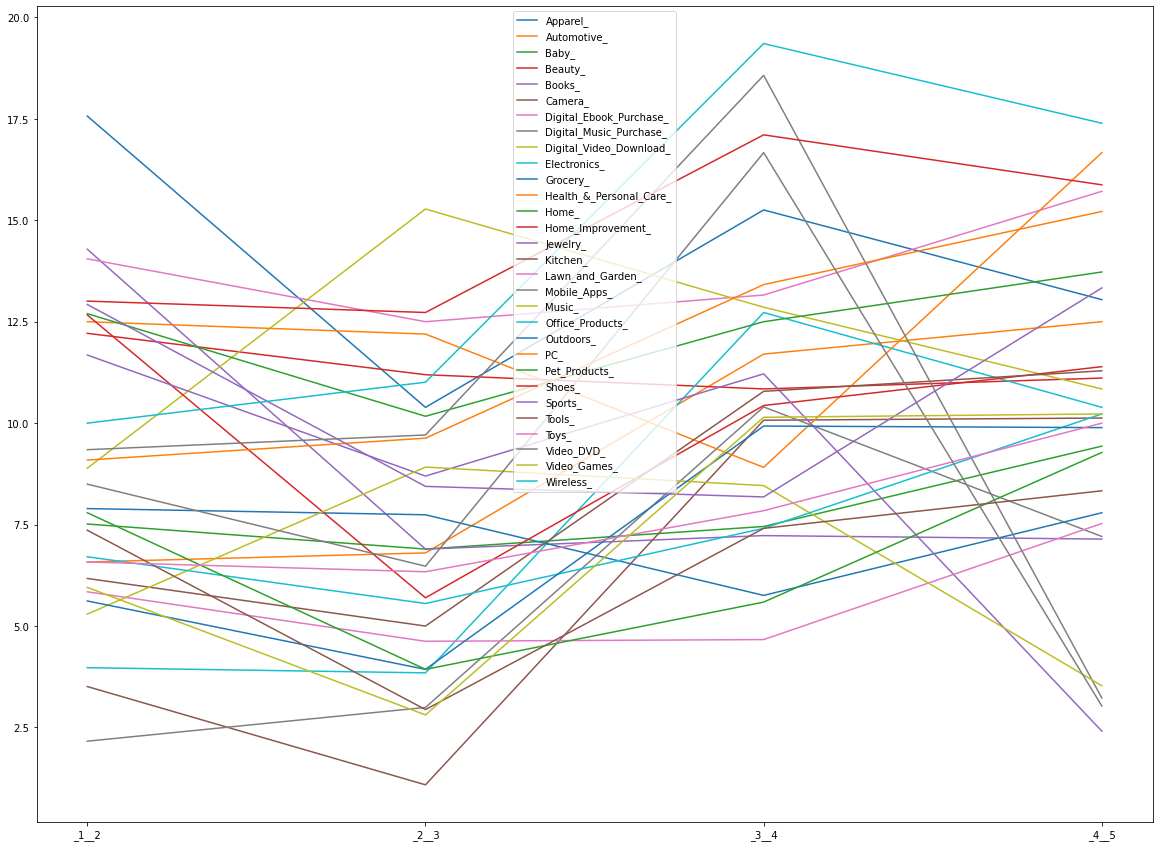

In [241]:
tfidf_scores_star_rating = prepare_data_for_tfidf(df_product_category_rating, grouping_type = 'star')
df_overlaps_tfidf_star_rating = calc_star_rating_overlap_tfidf(tfidf_scores_star_rating)
plot_star_overlap(df_overlaps_tfidf_star_rating)

**Notes:** The analysis allows us to examine the language overlap between star ratings across the different product categories. One interpretation of this analysis would be that the language used in reviews from Lower star ratings, e.g. 1 or 2 stars is different to that of 3 stars (maybe due to the negative terms, where as we can see overlap in terms between reviews which are 3 and 4 stars (on the graph we can see this by looking at the points between _2_3 and _3_4). We can also explore the different product categories, and note different ranges of overlap

---

### TF-IDF: Build a Multi-class Classifier to Determine a Review Category

In this method, we're going to take our learnins from the Tf-IDF experimentation, an train a simple baseline classification model to determine how well the Tf-IDF vectors represent the categories within the dataset.

The First approach will be to build the classifier with only a smaller number of categories (e.g. not segmented by year), and depending ont he results, we will start to increase the dataset labels granularity.


In [243]:
def train_bayes_classifier_product_category(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    ys =  df['product_category']
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose =2)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_cat, count_vect_cat, X_test_cat, y_test_cat = train_bayes_classifier_product_category(sampled_data)

1437684 1437684
Training Data Size: 1078263
[LibLinear]

In [244]:
def predict(model, count_vect, X_test, y_test):
    
    X_test_counts = count_vect.transform(X_test)
    y_preds = model.predict(X_test_counts)
    print(y_preds)
    
    print(metrics.classification_report(y_test, y_preds))
   
predict(model_cat, count_vect_cat, X_test_cat, y_test_cat)

['Video_DVD' 'Video_DVD' 'Music' ... 'Digital_Video_Download' 'Wireless'
 'Digital_Video_Download']
                        precision    recall  f1-score   support

               Apparel       0.55      0.69      0.61     15334
            Automotive       0.54      0.45      0.49      8824
                  Baby       0.40      0.51      0.45      4146
                Beauty       0.60      0.66      0.63     12596
                 Books       0.64      0.79      0.71     48164
                Camera       0.61      0.61      0.61      4333
Digital_Ebook_Purchase       0.69      0.57      0.62     42637
Digital_Music_Purchase       0.77      0.32      0.45      4022
Digital_Video_Download       0.59      0.40      0.47      9788
           Electronics       0.56      0.49      0.53      8007
               Grocery       0.65      0.68      0.66      5875
Health_&_Personal_Care       0.51      0.37      0.43     12910
                  Home       0.53      0.37      0.44     15425
   

**Notes**: From the results of the Tf-IFD vector implementation for modelling, the results generally look pretty accurate for both precision and recall, across all classes. It's important to remember this based on a 1% sample of the total dataset, and that we're filtering lots of the terms

The uses of this model could be to customer or operations focused,

### Model for Product Category and Star Rating

Once we've obtained our TF-IDF scores for our specific words, we can then use a Support Vector Machine to develop a simple multi-class classifier. Whilst this is not recommended for larger datasets (SVMs require intensive memory allocation due to the technique to map high-dimentionality), it's useful as a tool to detemrine how predictive this technique could be.

In [245]:
def train_svc_classifier_product_category_star_rating(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    df["label"] = df["product_category"].astype(str) +'_stars_'+  df["star_rating"].astype(str)
    ys =  df['label']
#     print(ys)
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose = 1)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_stars, count_vect_stars, X_test_stars, y_test_stars = train_svc_classifier_product_category_star_rating(sampled_data)

1437684 1437684
Training Data Size: 1078263
[LibLinear]

In [246]:
predict(model_stars, count_vect_stars, X_test_stars, y_test_stars)

['Video_DVD_stars_5' 'Video_DVD_stars_5' 'Music_stars_4' ...
 'Digital_Video_Download_stars_1' 'Wireless_stars_5'
 'Digital_Video_Download_stars_5']
                                precision    recall  f1-score   support

               Apparel_stars_1       0.25      0.34      0.29      1197
               Apparel_stars_2       0.16      0.04      0.06       956
               Apparel_stars_3       0.20      0.07      0.10      1661
               Apparel_stars_4       0.24      0.15      0.18      3002
               Apparel_stars_5       0.37      0.60      0.46      8518
            Automotive_stars_1       0.22      0.12      0.16       766
            Automotive_stars_2       0.09      0.02      0.03       341
            Automotive_stars_3       0.06      0.01      0.02       619
            Automotive_stars_4       0.15      0.03      0.04      1286
            Automotive_stars_5       0.43      0.42      0.42      5812
                  Baby_stars_1       0.07      0.13      0

**Notes**: As expected, when developing a model for multi-class classification problems, as the class space becomes large, the level of accuracy across classes will drop accordingly. This experiment was mainly to determine the seperation of reviews between star ratings, in relation to the product_cateogy, and then, to determine the cross-over in terminology used between star ratings, segmented by product_category

## Analysis 2: Word Embeddings

In the following section we're going to explore state-of-the-art models to perform product category prediction, in order to determine how much improvement we can obtain by using recent techniques for NLP

### Word Embeddings Using BlazingText (Supervised)
BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "_ _label_ _".

In [ ]:
train_file = 'amazonreviews.train'
test_file = 'amazonreviews.test'

In [ ]:
def prep_data_for_supervised_blazing_text(df, train_file_output_name, test_file_output_name):
    
    label_prefix = "__label__"    
    labels = (label_prefix + df['product_category']).tolist()
    #and tokenized words
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        res = ' '.join(res)
        xs.append(res)
    
   
    #ensure the lengths
    print('Reviews {}, Labels {}'.format(len(xs), len(labels)))
    
    
    
    #split the data into test and train for supervised mode
    X_train, X_test, y_train, y_test = train_test_split(
        xs, labels, random_state = 0)
    
    
    train_prepped = []
    #train
    for i in range(0, len(X_train)):
        row = str(y_train[i]) + " " + str(X_train[i])
        train_prepped.append([row])
    print('Example Train Processed Data: {}'.format(train_prepped[0]))
    
    test_prepped = []
    #train
    for i in range(0, len(X_test)):
        row = str(y_test[i]) + " " + str(X_test[i])
        test_prepped.append([row])
    print('')
    print('Example Test Processed Data: {}'.format(test_prepped[0]))
    
    with open(train_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)
        csv_writer.writerows(train_prepped)

    with open(test_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)        
        csv_writer.writerows(test_prepped)

        
prep_data_for_supervised_blazing_text(sampled_data, train_file , test_file)         
    

In [ ]:
def upload_corpus_to_s3(configs, global_vars, train_file , test_file):
    
    
    train_prefix = 'train'
    test_prefix = 'test'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
   
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], train_prefix, train_file)
    s3_bucket.upload_file(train_file, data_file_s3)   

    
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], test_prefix, test_file)
    s3_bucket.upload_file(test_file, data_file_s3) 
    
    
    s3_train_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], train_prefix)
    s3_test_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], test_prefix)
    s3_output_location = 's3://{}/{}/output'.format(configs['bucket_name'], configs['wordvecdata'])
    
    configs['s3_w2v_train_data'] = s3_train_data
    configs['s3_w2v_test_data'] = s3_test_data
    configs['s3_w2v_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Test Data Path {}'.format(s3_test_data))

    print('S3 output Data Path {}'.format(s3_output_location))

    return configs

configs = upload_corpus_to_s3(configs, global_vars, train_file , test_file)     

In [ ]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c5.18xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_w2v_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="supervised",
                                 epochs=20,
                                 min_count=2,
                                 learning_rate=0.05,
                                 vector_dim=10,
                                 early_stopping=False,
                                 patience=4,
                                 min_epochs=10,
                                 word_ngrams=4)
    
    train_data = sagemaker.session.s3_input(configs['s3_w2v_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    
    validation_data = sagemaker.session.s3_input(configs['s3_w2v_test_data'], distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
    
    data_channels = {'train': train_data, 'validation': validation_data}
    
   
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

In [ ]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

In [ ]:
def host_model(global_vars):
    
    bt_model = global_vars['bt_model']
    text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
    global_vars['w2v_classifier'] = text_classifier
    
    return global_vars

global_vars = host_model(global_vars)

In [ ]:
def evaluate_test_data_against_model(global_vars, test_file):
    
    train_data = []
    instances = []
    with open(test_file, 'r', newline= '\n') as csvinputfile:
        data = csv.reader(csvinputfile)
        for row in data:
#             print(row)
            label = row[0].split(' ')[0]
            text = row[0].partition(' ')[2].replace('  ',' ').strip()
            tmp = {'label':label, "text":text}
            train_data.append(tmp)
#             print(tmp)
#             break
            #same order as the csv rows
            instances.append(text)
            
            

    print('Total Instances {}. Total Train Data {}'.format(len(instances), len(train_data)))

#     print(instances[0], train_data[0]['label'])
    
    # we need to do some batch inferencing due to the size of the data:
    
    #each batch is 1000 sentences
    batch_size = 10000
    batches = len(instances) // batch_size
    
    print('Batches {}'.format(batches))
    
    predictions_batches = []
    
    for i in range(0, batches+1):
        lower = batch_size * i
        upper = batch_size * (i+1)
        if i == batches:
            upper = len(instances)
        print('Batch {} : {}'.format(lower,upper))
            
        instances_batch = instances[lower:upper]
        
        payload = {"instances":instances_batch,
                  "configuration": {"k": 1}}

        text_classifier =  global_vars['w2v_classifier']


        response = text_classifier.predict(json.dumps(payload))

        predictions = json.loads(response)
        predictions_batches.append(predictions)
        
#     print(json.dumps(predictions, indent=2))
    print('Total Predictions {}'.format(len(predictions)))
        
    return predictions_batches, train_data
            
            
                
predictions_batches, train_data = evaluate_test_data_against_model(global_vars, test_file)

In [ ]:
def evaluate_model_predictions(predictions_batches, train_data):
    
    preds = []
    for batch in predictions_batches:
        for pred in batch:
            lab = pred['label'][0]
            prob = pred['prob'][0]
            tmp = {'pred_label':lab, 'pred_prob':prob}
            preds.append(tmp)
            
    print('Total Preds {}'.format(len(preds)))
    
    for i in range(0,len(train_data)):
        data = train_data[i]
        true_label = data['label']
        preds[i]['true_label'] = true_label
        
    print('Example Data: \n\t {}'.format(preds[1]))
    
    y_true = []
    y_pred = []
    for pred in preds:
        y_true.append(pred['true_label'].replace('__label__',''))
        y_pred.append(pred['pred_label'].replace('__label__',''))
        
    print(classification_report(y_true, y_pred))

        
evaluate_model_predictions(predictions_batches, train_data)

**Notes**: Using the Word2Vec word Embedding approach, we're seeing similar results to the TF-IDF/SVC implementation for predicting product category. However, the computational time required to compute the SVC was nearly 100 times slower than the Word2Vec approach, and this is only for a sample dataset of 1% of the total data.

## Approach 3: Bidirectional Encoder Representations from Transformers (BERT)

https://huggingface.co/transformers/model_doc/bert.html#overview

In [ ]:
# !pip install --upgrade pip
# !pip install tensorflow

In [8]:
from transformers import DistilBertTokenizer, BertTokenizer, DistilBertModel, BertModel
from multiprocessing import  Pool
import multiprocessing as mp
import torch.multiprocessing as torchmp
from functools import partial
import tensorflow as tf
from transformers import (
    BertConfig, 
    BertTokenizer,
    TFBertForSequenceClassification
)

from collections import namedtuple
from typing import List, Tuple

In [9]:
def set_bert_configs(configs, batch_size, epochs):
    configs['bert_model_type'] = 'bert-base-uncased'
    configs['bert_epochs'] = 3
    configs['bert_batch_size'] = 1024
    configs['model_path'] = 'model/bert_tf_model_uncased_amazon_reviews_fine_tuned'
    return configs

configs = set_bert_configs(configs, batch_size = 1024, epochs = 3)

### View Training Of Model

In [79]:
def describe_model(configs):
    
    TO_FINETUNE = configs = configs['bert_model_type']
    num_examples = len(tuples)
    config = BertConfig.from_pretrained(TO_FINETUNE)
    model = TFBertForSequenceClassification.from_pretrained(TO_FINETUNE, config=config) 
    model.summary()

describe_model(configs)
    

Model: "tf_bert_for_sequence_classification_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_493 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  23070     
Total params: 109,505,310
Trainable params: 109,505,310
Non-trainable params: 0
_________________________________________________________________


In [10]:
def create_label_mapping(df):
    
    num_labels = df['product_category'].nunique()
    labels_unique = df['product_category'].unique()
    print('Number of Classes {}'.format(num_labels))
    
    labels = df['product_category'].tolist()
    #convert to index for reversals
    labels_unique_name_idx = { labels_unique[i] :  i for i in range(0, len(labels_unique) ) }
    labels_unique_idx_name = { i : labels_unique[i] for i in range(0, len(labels_unique) ) }
#     print(labels_unique_name_idx)
    
    labels_idx_col = []
    for lab in labels:
        if lab in labels_unique_name_idx:
            labels_idx_col.append(labels_unique_name_idx[lab])
    
    df['label'] = labels_idx_col
    
#     display(df)

    return df, labels_unique_idx_name, num_labels

sampled_data, labels_mapping, num_labels = create_label_mapping(sampled_data)

Number of Classes 30


In [11]:
def create_text_column(df,text_col):
    
    col_to_add = 'processed_text'
    tmp = df[text_col]
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        res = ' '.join(res)
        xs.append(res)
        
    df['processed_text'] = xs
#     display(df)
    return df

sampled_data = create_text_column(sampled_data, 'review_body_processed')

In [12]:
def create_train_test_data(df):
    
    xs = []
    ys = []
    
    for row in df.itertuples(index=False):
        xs.append(row.processed_text)
        ys.append(row.label)

    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, test_size=0.20, random_state = 0)
    
    print("Train Dataframe Length {},  Test Dataframe Length {}".format(len(X_train), len(X_test)))
    
    train_df = pd.DataFrame(list(zip(X_train, y_train)), 
               columns =['processed_text', 'label']) 
 
    test_df = pd.DataFrame(list(zip(X_test, y_test)), 
               columns =['processed_text', 'label']) 
    
    return train_df, test_df 
    
    
    
train_df, test_df = create_train_test_data(sampled_data)

Train Dataframe Length 1150147,  Test Dataframe Length 287537


In [18]:
def build_tf_tuples(df):
    
    InputExample = namedtuple('InputExample', ['text', 'category_index'])
    
    data = []
    for row in df.itertuples(index=False):
        data.append(InputExample(text=row.processed_text, category_index=row.label))
        
    return data

# tf_tuples =  build_tf_tuples(train_df)

In [19]:
def convert_examples_to_tf_dataset(examples: List[Tuple[str, int]],tokenizer, max_length=512,):
    """
    Loads data into a tf.data.Dataset for finetuning a given model.
    Args:
        examples: List of tuples representing the examples to be fed
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum string length
    Returns:
        a ``tf.data.Dataset`` containing the condensed features of the provided sentences
    """
    features = [] # -> will hold InputFeatures to be converted later
    InputFeatures = namedtuple('InputFeatures', ['input_ids', 'attention_mask', 'token_type_ids', 'label'])

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
        )

        # input ids = token indices in the tokenizer's internal dict
        # token_type_ids = binary mask identifying different sequences in the model
        # attention_mask = binary mask indicating the positions of padded tokens so the model does not attend to them

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.category_index
            )
        )
            
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )



In [20]:
def generate_tensors(configs, tuples, num_labels):
    
    BATCH_SIZE = 16
    num_examples = len(tuples)
    TO_FINETUNE = configs['bert_model_type']
    config = BertConfig.from_pretrained(TO_FINETUNE, num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained(TO_FINETUNE)
    
    # Make the CPU do all data pre-processing steps, not the GPU
    with tf.device('/cpu:0'):
        train_data = convert_examples_to_tf_dataset(tuples, tokenizer)
        
        train_data = train_data.shuffle(buffer_size=num_examples, reshuffle_each_iteration=True) \
                               .batch(BATCH_SIZE) \
                               .repeat(-1)
        
    return train_data

# tf_train_data = generate_tensors(configs, tf_tuples, num_labels)

In [ ]:
def train_model_with_new_layer_classes(configs, global_vars, train_data, tuples, num_labels):
    
    EPOCHS = configs['bert_epochs']
    BATCH_SIZE = configs['bert_batch_size']
    TO_FINETUNE = configs['bert_model_type']
    num_examples = len(tuples)

    config = BertConfig.from_pretrained(TO_FINETUNE, num_labels=num_labels)
    model = TFBertForSequenceClassification.from_pretrained(TO_FINETUNE, config=config)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-05, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='accuracy')
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

    train_steps = num_examples // BATCH_SIZE

    model.fit(train_data, 
              epochs=EPOCHS,
              steps_per_epoch=train_steps,
#               verbose=2,
              callbac ks=[tensorboard_callback]
             )
    
    global_vars['bert_tf_model'] = model
    global_vars['tensorboard_callback'] = tensorboard_callback
    configs['log_dir'] = log_dir
    
    print('Fitting Data to Pre-trained Model')
    
    return global_vars, configs

global_vars, configs = train_model_with_new_layer_classes(configs, global_vars, tf_train_data,tf_tuples,num_labels)

Train for 1403 steps
Epoch 1/3
 782/1403 [===============>..............] - ETA: 4:40:36 - loss: 1.3886 - accuracy: 2.8338

### Save Model Weights

In [163]:
def save_model_weights(model, path):
    
    model.save_weights(path)
    
# os.mkdir('model/')
save_model_weights(global_vars['bert_tf_model'], 'model/bert_tf_model_uncased_amazon_reviews_fine_tuned.ckpt')

In [177]:
def save_model(model, path):
    
    model.save_pretrained(save_directory=path)
    
    
# model = global_vars['bert_tf_model']

os.mkdir(model_path)
save_model(global_vars['bert_tf_model'], configs['model_path'])


### Save Model File

In [130]:
import tarfile

def tar_model(model_path):
    print('Compressing model to Tar File')
    with tarfile.open('model/model.tar.gz', mode='w:gz') as archive:
        archive.add(model_path, recursive=True)

tar_model(configs['model_path'] )

Compressing model to Tar File


### Load Model

Only use this if you're loading the pre-trained fine tuned model

In [24]:
def load_model(global_vars, model_path):
    
    model = TFBertForSequenceClassification.from_pretrained(model_path)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-05, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='accuracy')
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])
    
    model.summary()

    global_vars['bert_tf_model'] = model
    return global_vars
    
global_vars =  load_model(global_vars, configs['model_path'] )

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  23070     
Total params: 109,505,310
Trainable params: 109,505,310
Non-trainable params: 0
_________________________________________________________________


### Evaluate Model

In [36]:
def evaluate_model(configs, model, df, labels_mapping):
    
    TO_FINETUNE = configs['bert_model_type']
    config = BertConfig.from_pretrained(TO_FINETUNE)
    tokenizer = BertTokenizer.from_pretrained(TO_FINETUNE)
    TEST_STEPS = 100
    y_preds = []
    y = []
    inputs = []
    num_labels = len(labels_mapping)
    tf_test_tuples =  build_tf_tuples(df)
    tf_test_data = generate_tensors(configs, tf_test_tuples, num_labels)

    callbacks = []

    log_dir = "logs/eval/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks.append(tensorboard_callback)

    test_history = model.evaluate(tf_test_data,
                             steps=TEST_STEPS,
                              callbacks=callbacks,
                                 verbose=3)
    
    return test_history# y, y_preds


test_history = evaluate_model(configs, global_vars['bert_tf_model'], test_df, labels_mapping )

In [ ]:
from transformers import TextClassificationPipeline

def evaluate_data_for_confusion_matrix(configs, model, df, labels_mapping):
    
    TO_FINETUNE = configs['bert_model_type']
    config = BertConfig.from_pretrained(TO_FINETUNE)
    tokenizer = BertTokenizer.from_pretrained(TO_FINETUNE)
    
    inference_pipeline = TextClassificationPipeline(model=model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=-1) # -1 is CPU, >= 0 is GPU
    
    y, y_preds = [], []
    cnt = 0
    for idx,row in df.iterrows():
#         print(idx)
#         test_data = tokenizer.encode_plus(row['processed_text'], return_tensors="tf", max_length=512)
#         outputs = model(test_data)
#         print(inference_pipeline(row['processed_text']))
        preds = inference_pipeline(row['processed_text'])
        pred_lab = int(preds[0]['label'].replace('LABEL_',''))
#         classification_scores = 
        y_preds.append(labels_mapping[pred_lab])
        y.append(labels_mapping[row['label']])
#         print(y_preds)
#         print(y)
        cnt += 1
        if cnt % 5 == 0:
            
            total_predictions = len(y)
            correct_predictions = 0
            for i in range(0,len(y_preds)):
                if y_preds[i] == y[i]:
                    correct_predictions += 1
            classification_accuracy = correct_predictions / total_predictions * 100.0
            print('Step  {} of {}'.format(cnt, df.shape[0]))
            print('Eval Classification Accuracy: {}'.format(classification_accuracy))
                
            
    return y, y_preds

#run this with the test data
y, y_preds = evaluate_data_for_confusion_matrix(configs, 
                                                  global_vars['bert_tf_model'], 
                                                  test_df, 
                                                  labels_mapping )

Step  5 of 287537
Eval Classification Accuracy: 60.0
Step  10 of 287537
Eval Classification Accuracy: 60.0
Step  15 of 287537
Eval Classification Accuracy: 46.666666666666664
Step  20 of 287537
Eval Classification Accuracy: 50.0
Step  25 of 287537
Eval Classification Accuracy: 52.0
Step  30 of 287537
Eval Classification Accuracy: 53.333333333333336
Step  35 of 287537
Eval Classification Accuracy: 54.285714285714285
Step  40 of 287537
Eval Classification Accuracy: 55.00000000000001
Step  45 of 287537
Eval Classification Accuracy: 55.55555555555556
Step  50 of 287537
Eval Classification Accuracy: 54.0
Step  55 of 287537
Eval Classification Accuracy: 58.18181818181818
Step  60 of 287537
Eval Classification Accuracy: 60.0
Step  65 of 287537
Eval Classification Accuracy: 61.53846153846154
Step  70 of 287537
Eval Classification Accuracy: 58.57142857142858
Step  75 of 287537
Eval Classification Accuracy: 56.00000000000001
Step  80 of 287537
Eval Classification Accuracy: 56.25
Step  85 of 2875

### Upload BERT Model to S3

In [142]:
def upload_bert_to_s3(configs, global_vars, model_tar):
    
    
    models_dir = configs['models_dir']
    prefix = 'bert'
    model_s3_filename = 'model.tar.gz'
    
    s3_bucket = global_vars['s3_bucket']
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
   
    

    model_file_s3 = '{}/{}/{}'.format(models_dir, prefix, model_s3_filename)
    s3_bucket.upload_file(model_tar, model_file_s3)   

   
    
    
    s3_bert_model = 's3://{}/{}/{}/model.tar.gz'.format(configs['bucket_name'], models_dir, prefix)
    
    configs['s3_bert_model'] = s3_bert_model
   
    print('S3 BERT Data Path {}'.format(s3_bert_model))
   

    return configs

model_tar = 'model/model.tar.gz'
configs = upload_bert_to_s3(configs, global_vars, model_tar)     

S3 BERT Data Path s3://demos-amazon-reviews/models/bert/model.tar.gz


## Findings from TF-IDF, Word2Vec, BERT

In this notebook we have explored a sample of the dataset, and then applied a variety of text analysis methods to understand the application of natural language processsing techniques to perform classification and prediction of an Amazon Review product category.

What we've learnt is that depending on the method (TF-IDF, Word Embeddings va blazingtext, and BERT), the speed of training and inferencing as we increase the complexity of the method (e.g. BERT being the most complex), however, we do see an increase in classifcation score as a result.

With our 1% sample which has been taken from a fair distribution of the total 140 million reviews, we can see the performance for multi-class classification performs as follows:

- TF-IDF (using SVC for classification) - 65%
- Word Embeddings - 75%
- BERT - 82%

Let's consider the computational time taken to train and then perform inferencing (local model):

- TF-IDF - Training: 10 minutes. Inferencing: < ~1ms
- Word-Embeddings - This was using SageMaker distributed mode so cannot compare
- BERT - Training: 18 hours. Inferencing: ~15 seconds (per sample)

Conclusion:

- BERT represents the state-of-the-art technique for performing NLP tasks such as sequence classification, however due to the complexity of the model, the training and the inferening is costly w.r.t time and computational resources. Whilst this was performed on on local mode, we should be able to scale up the processing time for training, the inferencing time will be similar to the response of that of the local mode, due to inferencing is not a distributed task.
- TF-IDF provided adequate results, however, due to two part approach to TF-IDF - first undsupervised training to identify frequency and document frequency scores, then using these scores to train a classifier - the amount of heavy lifting is substantial. There was a significant amount of data preparation and tuning that was required in order to acheive adequate results. Also, TF-IDF cannot capture the semantics of the words, thus makes it difficult to use the outputs for other tasks. Furthermore, as we had to train a classifier on the back of the TF-IDF scores, it would be significantly slower (and require extensive computational resources), if we were to move to the full dataset.
- Word Embeddings: Word Embeddings provided the best of both worlds, it allows for the semantics of the tokens to persist within the training cycles (we can set the size of the n-grams we wish to keep), plus it provides acceptable results (> 75%) for classifying reviews based on their product_category

Going forward, we'll take the Word Embeddings Model and apply it to the larger corpus of reviews.


